In [5]:
from Bio.Seq import Seq
from Bio.SeqUtils import MeltingTemp as mt
from itertools import product, islice
import re
from concurrent.futures import ProcessPoolExecutor, as_completed
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from nupack import *
import random
# Define the model
model1 = Model(material='dna', ensemble='stacking', celsius=16, sodium=1, magnesium=0.00)

In [6]:
class ComplexNotFound(Exception):
    """Exception when a complex is not found."""
    pass

def get_complex_concentration(complexes, s1_index, s2_index):
    """Retrieve concentration, trying both orderings."""
    complex_name_1 = f's{s1_index}+s{s2_index}'
    complex_name_2 = f's{s2_index}+s{s1_index}'
    
    for complex_key, concentration in complexes.items():
        if complex_key.name in [f'({complex_name_1})', f'({complex_name_2})']:
            return concentration, complex_key.name.strip('()')
    
    raise ComplexNotFound(f"Complex '{complex_name_1}' or '{complex_name_2}' not found.")



In [25]:
# Initialize strands from sequences, make sure forward + reverse order
sequences = """
ACACACTCA
TGAGTGTGT
ACCAGAACA
TGTTCTGGT
ACCTCAACA
TGTTGAGGT
AGATGCGTA
TACGCATCT
AGCGATGTA
TACATCGCT
ATCGTGCTA
TAGCACGAT
ATTCGCCTA
TAGGCGAAT
TAACAGCCA
TGGCTGTTA
TAAGCCACA
TGTGGCTTA
TACAAGGCA
TGCCTTGTA
TACCAAGCA
TGCTTGGTA
TAGGTTGCA
TGCAACCTA
""".split()

strands = [Strand(seq, name=f's{i+1}') for i, seq in enumerate(sequences)]
tube_all = Tube({strand: 10e-9 for strand in strands}, SetSpec(max_size=2), name='all_in_one')

# Perform complex analysis and concentration calculations
result_all = complex_analysis(complexes=tube_all.complexes, model=model1, compute=['pfunc'])
conc_results_all = complex_concentrations(tube=tube_all, data=result_all)

# Simplified access to concentration data
tube_result_all = conc_results_all.tubes[tube_all]

# Generate complex names and print them
complex_names = [f'(s{i}+s{i+1})' for i in range(1, len(strands), 2)]
print("Generated Complex Names:", complex_names)

# Retrieve and organize concentration data for printing
complex_concentration_pairs_with_info = []
for i in range(1, len(strands), 2):
    concentration, used_complex_name = get_complex_concentration(tube_result_all.complex_concentrations, i, i+1)
    concentration *= 1e9  # nM conversion

    # Fetch actual sequences using indices and create descriptive names
    seq1, seq2 = sequences[i-1], sequences[i]
    descriptive_names = f'{seq1} + {seq2}'
    
    complex_concentration_pairs_with_info.append((used_complex_name, descriptive_names, concentration))

# Sort and print the organized data
sorted_concentrations = sorted(complex_concentration_pairs_with_info, key=lambda x: x[2], reverse=True)
for complex_id, names, concentration in sorted_concentrations:
    print(f"{complex_id} ({names}) is {concentration:.2f} nM")

    
# Organizing sequence data and handling sorting by concentration
complex_concentration_pairs_with_info = []
for i in range(0, len(sequences), 2):
    if i + 1 < len(sequences):  # Check if there's a next sequence
        concentration, used_complex_name = get_complex_concentration(tube_result_all.complex_concentrations, i + 1, i + 2)
        concentration *= 1e9  # Convert to nM
    else:
        concentration = 0  # Default or calculated value for single last sequence if needed
        used_complex_name = f's{i+1}'

    seq1 = sequences[i]
    complex_concentration_pairs_with_info.append((used_complex_name, seq1, concentration))

    if i + 1 < len(sequences):
        seq2 = sequences[i+1]
        complex_concentration_pairs_with_info.append((used_complex_name, seq2, concentration))

# Sort by concentration, ensuring that sequences with higher concentrations are printed first
sorted_concentrations = sorted(complex_concentration_pairs_with_info, key=lambda x: x[2], reverse=True)

# Print each sequence on its own line
print("\n\nSequence Pairs From High to Low Concentration")
for _, sequence, _ in sorted_concentrations:
    print(sequence)
print(len(sorted_concentrations))

Generated Complex Names: ['(s1+s2)', '(s3+s4)', '(s5+s6)', '(s7+s8)', '(s9+s10)', '(s11+s12)', '(s13+s14)', '(s15+s16)', '(s17+s18)', '(s19+s20)', '(s21+s22)', '(s23+s24)']
s15+s16 (TAACAGCCA + TGGCTGTTA) is 9.66 nM
s19+s20 (TACAAGGCA + TGCCTTGTA) is 9.64 nM
s21+s22 (TACCAAGCA + TGCTTGGTA) is 9.64 nM
s11+s12 (ATCGTGCTA + TAGCACGAT) is 9.63 nM
s7+s8 (AGATGCGTA + TACGCATCT) is 9.63 nM
s9+s10 (AGCGATGTA + TACATCGCT) is 9.62 nM
s17+s18 (TAAGCCACA + TGTGGCTTA) is 9.62 nM
s13+s14 (ATTCGCCTA + TAGGCGAAT) is 9.57 nM
s1+s2 (ACACACTCA + TGAGTGTGT) is 9.55 nM
s3+s4 (ACCAGAACA + TGTTCTGGT) is 9.52 nM
s5+s6 (ACCTCAACA + TGTTGAGGT) is 9.51 nM
s23+s24 (TAGGTTGCA + TGCAACCTA) is 9.37 nM


Sequence Pairs From High to Low Concentration
TAACAGCCA
TGGCTGTTA
TACAAGGCA
TGCCTTGTA
TACCAAGCA
TGCTTGGTA
ATCGTGCTA
TAGCACGAT
AGATGCGTA
TACGCATCT
AGCGATGTA
TACATCGCT
TAAGCCACA
TGTGGCTTA
ATTCGCCTA
TAGGCGAAT
ACACACTCA
TGAGTGTGT
ACCAGAACA
TGTTCTGGT
ACCTCAACA
TGTTGAGGT
TAGGTTGCA
TGCAACCTA
24


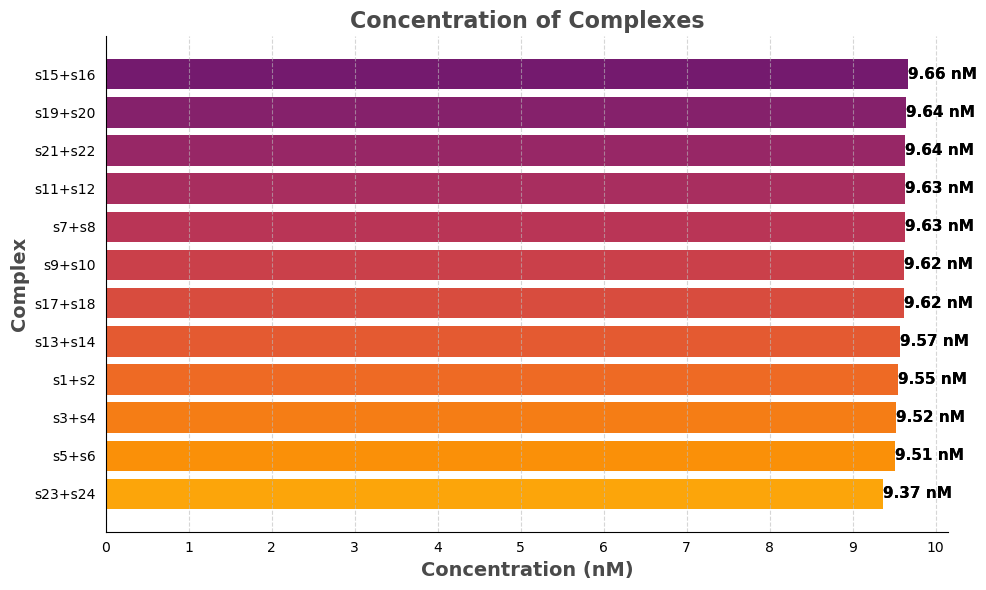

In [23]:
plt.figure(figsize=(10, 6))
n = len(sorted_concentrations)
colors = plt.cm.inferno(np.linspace(0.3, 0.8, n))
bars = plt.barh([complex_id for complex_id, _, _ in sorted_concentrations],
                [concentration for _, _, concentration in sorted_concentrations],
                color=colors)

plt.xlabel('Concentration (nM)', fontsize=14, fontweight='bold', color='#4A4A4A')
plt.ylabel('Complex', fontsize=14, fontweight='bold', color='#4A4A4A')
plt.title('Concentration of Complexes', fontsize=16, fontweight='bold', color='#4A4A4A')

plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6, color='#BBBBBB')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True, color='#4A4A4A')
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=True, color='#4A4A4A')

# Setting x-axis ticks to display whole numbers
max_concentration = max([concentration for _, _, concentration in sorted_concentrations])
plt.xticks(np.arange(0, max_concentration + 1, 1))  # Adjust step to 1 to include every integer

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.2f} nM', va='center', ha='left',
             color='black', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


In [26]:
# sequences = """
# TAACAGCCA 
# TGGCTGTTA
# TACAAGGCA
# TGCCTTGTA
# TACCAAGCA
# TGCTTGGTA
# ATCGTGCTA
# TAGCACGAT
# AGATGCGTA
# TACGCATCT
# AGCGATGTA
# TACATCGCT
# TAAGCCACA
# TGTGGCTTA
# """.split()

# calculate the free energy values for all sequences
table = []
for seq1 in sequences:
    row = []
    for seq2 in sequences:
        energy = pfunc([seq1, seq2], model=model1)[1]
        row.append(round(energy,2))
    table.append(row)

# create a pandas dataframe from the table
df = pd.DataFrame(table, index=sequences, columns=sequences)

# highlight the minimum value in each column
df.style.highlight_min(axis=0, color='green')

,ACACACTCA,TGAGTGTGT,ACCAGAACA,TGTTCTGGT,ACCTCAACA,TGTTGAGGT,AGATGCGTA,TACGCATCT,AGCGATGTA,TACATCGCT,ATCGTGCTA,TAGCACGAT,ATTCGCCTA,TAGGCGAAT,TAACAGCCA,TGGCTGTTA,TAAGCCACA,TGTGGCTTA,TACAAGGCA,TGCCTTGTA,TACCAAGCA,TGCTTGGTA,TAGGTTGCA,TGCAACCTA
ACACACTCA,-2.810000,-16.460000,-6.140000,-7.060000,-2.880000,-8.930000,-7.110000,-5.080000,-7.620000,-5.070000,-8.510000,-6.220000,-5.090000,-6.540000,-5.450000,-7.120000,-5.480000,-9.220000,-5.970000,-6.830000,-5.490000,-6.820000,-7.090000,-5.510000
TGAGTGTGT,-16.460000,-4.150000,-7.250000,-5.770000,-8.610000,-3.520000,-4.920000,-7.560000,-4.910000,-7.930000,-5.950000,-8.140000,-5.980000,-4.950000,-7.560000,-5.770000,-8.840000,-5.600000,-7.470000,-5.670000,-6.950000,-5.640000,-5.760000,-6.990000
ACCAGAACA,-6.140000,-7.250000,-5.990000,-16.350000,-5.920000,-9.960000,-6.380000,-6.330000,-6.730000,-5.820000,-6.980000,-5.840000,-6.360000,-6.890000,-5.680000,-8.610000,-5.630000,-7.830000,-7.170000,-6.760000,-5.590000,-8.740000,-7.900000,-5.920000
TGTTCTGGT,-7.060000,-5.770000,-16.350000,-5.490000,-9.590000,-5.780000,-6.060000,-6.300000,-5.560000,-6.790000,-5.320000,-6.920000,-6.650000,-6.490000,-8.590000,-5.560000,-7.660000,-5.320000,-7.040000,-6.760000,-8.920000,-5.320000,-6.100000,-7.550000
ACCTCAACA,-2.880000,-8.610000,-5.920000,-9.590000,-2.950000,-16.350000,-6.770000,-4.870000,-6.970000,-4.860000,-6.140000,-5.950000,-4.960000,-7.810000,-5.160000,-7.790000,-5.180000,-7.710000,-7.360000,-6.790000,-5.180000,-7.740000,-9.500000,-5.280000
TGTTGAGGT,-8.930000,-3.520000,-9.960000,-5.780000,-16.350000,-3.500000,-5.100000,-7.290000,-4.940000,-7.380000,-5.990000,-6.290000,-7.760000,-5.040000,-8.350000,-5.780000,-7.520000,-5.610000,-7.410000,-7.530000,-8.170000,-5.640000,-5.720000,-9.740000
AGATGCGTA,-7.110000,-4.920000,-6.380000,-6.060000,-6.770000,-5.100000,-7.180000,-16.860000,-7.500000,-9.800000,-7.320000,-8.680000,-9.460000,-7.840000,-7.500000,-6.730000,-7.430000,-6.840000,-8.280000,-6.610000,-7.980000,-6.960000,-7.610000,-8.550000
TACGCATCT,-5.080000,-7.560000,-6.330000,-6.300000,-4.870000,-7.290000,-16.860000,-7.540000,-10.640000,-7.260000,-8.610000,-7.980000,-7.090000,-10.740000,-6.870000,-8.020000,-6.890000,-7.440000,-7.470000,-7.590000,-7.410000,-7.880000,-8.760000,-7.850000
AGCGATGTA,-7.620000,-4.910000,-6.730000,-5.560000,-6.970000,-4.940000,-7.500000,-10.640000,-7.760000,-16.860000,-9.010000,-8.250000,-10.300000,-7.710000,-8.000000,-7.260000,-6.940000,-7.110000,-10.090000,-6.460000,-8.270000,-7.240000,-7.000000,-7.110000
TACATCGCT,-5.070000,-7.930000,-5.820000,-6.790000,-4.860000,-7.380000,-9.800000,-7.260000,-16.860000,-6.890000,-7.490000,-8.990000,-6.730000,-10.870000,-7.110000,-7.970000,-7.160000,-7.290000,-7.150000,-9.450000,-7.710000,-8.240000,-7.370000,-7.220000
